In [1]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

from gensim import corpora, models, similarities, matutils
from sklearn.cluster import KMeans, DBSCAN


import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Data Setup

In [2]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [3]:
cursor = db_connection.cursor()

In [4]:
dfr = pd.read_sql("SELECT * FROM reddit", db_connection)

In [62]:
dfr_wod = dfr.drop_duplicates(subset=["title"]).copy()

# Cleaning Data

In [63]:
def clean_data(title):
    cleaned_title = re.sub(r"\W", " ", title)
    cleaned_title = cleaned_title.lower()
    return cleaned_title

In [64]:
def get_specifier(title):
    cleaned_title = re.findall(r"\[((\w|\/| )*)\]", title)
    
    #\[([homemade]|[i ate]|[pro/chef])*\]
    #"\[.*\]"
    
    if cleaned_title:
        cleaned_title = cleaned_title[0][0].lower()
        if cleaned_title in ["homemade", "i ate", "pro/chef"]:
            return cleaned_title
    return "other"
    

In [65]:
dfr_wod.insert(0, column="cleaned_title", value=dfr_wod["title"].apply(clean_data))

In [66]:
dfr_wod.insert(0, column="specifier_title", value=dfr_wod["title"].apply(get_specifier))

In [67]:
dfr_wod["specifier_title"].value_counts()

homemade    12452
i ate        1930
pro/chef      284
other           4
Name: specifier_title, dtype: int64

(array([2.8400e+02, 0.0000e+00, 0.0000e+00, 1.2452e+04, 0.0000e+00,
        0.0000e+00, 1.9300e+03, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

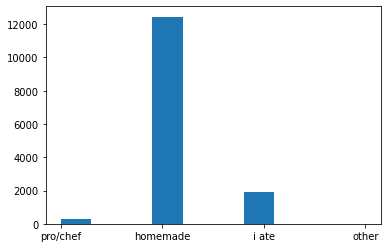

In [69]:
plt.hist(dfr_wod["specifier_title"])

In [12]:
dfr_wod.head()

,specifier_title,cleaned_title,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time
0,[pro/chef],pro chef texas barbecue platter,101,08,08:48:37,2021-02-08,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,0,1451,,https://b.thumbs.redditmedia.com/8dY2UPIltw6QD...,https://i.redd.it/zclugg5m75g61.jpg,2021-02-08 13:57:10.388548
1,[homemade],homemade whole lemon cake doughnuts with whi...,102,03,03:19:56,2021-02-08,jojofaye,[homemade] Whole lemon cake doughnuts with whi...,2508,0,38,,https://b.thumbs.redditmedia.com/voaO-2Yv62C7M...,https://i.redd.it/2dgjjzuxk3g61.jpg,2021-02-08 13:57:10.390814
2,[homemade],homemade calamari,103,07,07:18:47,2021-02-08,will20566,[Homemade] Calamari,848,0,23,,https://b.thumbs.redditmedia.com/s7gGC9-olz4cc...,https://i.redd.it/03mtxaalr4g61.jpg,2021-02-08 13:57:10.392863
3,[homemade],homemade raspberry cream cake covered in legos,104,18,18:49:38,2021-02-07,aka_scoch,[homemade] raspberry cream cake covered in Legos,18446,0,382,,https://b.thumbs.redditmedia.com/ql-XfyeTNstPp...,https://i.redd.it/dz168i5x11g61.jpg,2021-02-08 13:57:10.394895
4,[homemade],homemade yogurt eggs and apple fries,105,04,04:15:36,2021-02-08,Untoastedtoast390,[homemade] “yogurt eggs and apple fries”,1313,0,69,,https://b.thumbs.redditmedia.com/SMcQN2Uj1xpwA...,https://i.redd.it/37snzekwu3g61.jpg,2021-02-08 13:57:10.396900


# Text Clustering

In [13]:
corpus = dfr_wod["title"].copy(deep=True)

In [14]:
count_vectorize = TfidfVectorizer(stop_words="english")
vectorized = count_vectorize.fit_transform(dfr_wod['cleaned_title'])

In [22]:
cls = MiniBatchKMeans(n_clusters=4, random_state=0)
cls.fit(vectorized)

MiniBatchKMeans(n_clusters=4, random_state=0)

In [23]:
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(vectorized.toarray())

In [24]:
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

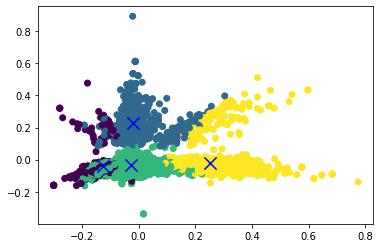

In [25]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vectorized))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [26]:
from sklearn.metrics import silhouette_score
silhouette_score(vectorized, labels=cls.predict(vectorized))

0.00987236973613513

# Topic Modelling

In [20]:
random_state = 0

In [49]:
def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output

In [50]:
dfr_wod["nouns"] = only_nouns(dfr_wod['title'])

In [51]:
dfr_wod.head()

,specifier_title,cleaned_title,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time,nouns
0,[pro/chef],pro chef texas barbecue platter,101,08,08:48:37,2021-02-08,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,0,1451,,https://b.thumbs.redditmedia.com/8dY2UPIltw6QD...,https://i.redd.it/zclugg5m75g61.jpg,2021-02-08 13:57:10.388548,
1,[homemade],homemade whole lemon cake doughnuts with whi...,102,03,03:19:56,2021-02-08,jojofaye,[homemade] Whole lemon cake doughnuts with whi...,2508,0,38,,https://b.thumbs.redditmedia.com/voaO-2Yv62C7M...,https://i.redd.it/2dgjjzuxk3g61.jpg,2021-02-08 13:57:10.390814,lemon cake doughnut ganache lemon shaving
2,[homemade],homemade calamari,103,07,07:18:47,2021-02-08,will20566,[Homemade] Calamari,848,0,23,,https://b.thumbs.redditmedia.com/s7gGC9-olz4cc...,https://i.redd.it/03mtxaalr4g61.jpg,2021-02-08 13:57:10.392863,
3,[homemade],homemade raspberry cream cake covered in legos,104,18,18:49:38,2021-02-07,aka_scoch,[homemade] raspberry cream cake covered in Legos,18446,0,382,,https://b.thumbs.redditmedia.com/ql-XfyeTNstPp...,https://i.redd.it/dz168i5x11g61.jpg,2021-02-08 13:57:10.394895,cream cake
4,[homemade],homemade yogurt eggs and apple fries,105,04,04:15:36,2021-02-08,Untoastedtoast390,[homemade] “yogurt eggs and apple fries”,1313,0,69,,https://b.thumbs.redditmedia.com/SMcQN2Uj1xpwA...,https://i.redd.it/37snzekwu3g61.jpg,2021-02-08 13:57:10.396900,egg apple fry


In [65]:
# number of topics to extract
n_topics = 7

vec = TfidfVectorizer(max_features=30000, stop_words="english", max_df=0.9, min_df=2, smooth_idf=False)
features = vec.fit_transform(dfr_wod["nouns"])

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

/home/jakob/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


NMF(n_components=7, random_state=0)

In [66]:
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 6

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 chicken sandwich wing curry salad thigh 
1 cake chocolate cream birthday cookie buttercream 
2 egg bacon toast raman pork roll 
3 pizza style pepperoni mushroom onion crust 
4 cheese potato sauce onion fry burger 
5 bread sourdough banana beef rye bowl 
6 rice pork beef bean style rib 


0 chicken sandwich wing curry salad thigh --> Asiatisch?
1 cake chocolate cream birthday cookie buttercream --> Kuchen/Süßspeisen 
2 egg bacon toast raman pork roll  --> Frühstück?
3 pizza style pepperoni mushroom onion crust --> Pizza/Vegetarisch?
4 potato sauce fry onion mushroom salad --> Vegetarisch
5 cheese bread onion cream burger soup --> Burger
6 rice pork beef bean rib style --> Rindfleisch/Grillen